# Exercice 7 - Application of Unsupervised Learning

Our goal is to find different customer profiles in order to optimize marketing technics. For this purpose, we used the following [dataset](https://archive.ics.uci.edu/dataset/352/online+retail). 

## Setup

In [48]:
from math import pi
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colormaps
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [49]:
# Load the dataset from Kaggle input
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding='latin1')

## Exploratory Data Analysis

In this part, we will focus on analyzing the distribution of variables that composed the dataset. We will try to find errors or gaps in values. First, let's print the shape of our data :

In [50]:
print("Shape of the dataset:", df.shape)
print("Columns of the dataset:", df.columns)
df.head(5)

Shape of the dataset: (541909, 8)
Columns of the dataset: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


We check if the dataset contains some duplicates, which could not occurs because of the `InvoiceDate` column. Indeed, a customer cannot do two commands at the same time. In our case there are some duplicates, therefore we remove them.

In [51]:
has_duplicates = df.duplicated().any()
if (has_duplicates):
    print("The dataset contains some duplicates")
    df.drop_duplicates(inplace=True)

The dataset contains some duplicates


We can see from this first analysis that some minimum values are negative, which should not be possible in the case of a quantity or a price. So we remove those values :

In [52]:
df[['Quantity', 'UnitPrice']].describe() # Basic stats for numerical columns
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

We also check if the `CustomerID` or `Description` columns are empty, in the case we remove the rows. We convert the `InvoiceData` into `datetime` python object :

In [53]:
df.dropna(subset=['CustomerID', 'Description'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Because we want to segmentate customers, we create the `customer_df` that will aggregate the average behavior of each customer :

In [54]:
customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'UnitPrice': 'mean', 
    'InvoiceDate': ['min', 'max'],
    'Country': 'first'
})

# We change columns names for better clarity
customer_df.columns = ['NumOrders', 'TotalQuantity', 'AvgUnitPrice', 'FirstPurchase', 'LastPurchase', 'Country']
customer_df.head(5)

,NumOrders,TotalQuantity,AvgUnitPrice,FirstPurchase,LastPurchase,Country
CustomerID,,,,,,
12346.0,1,74215,1.040000,2011-01-18 10:01:00,2011-01-18 10:01:00,United Kingdom
12347.0,7,2458,2.644011,2010-12-07 14:57:00,2011-12-07 15:52:00,Iceland
12348.0,4,2341,5.764839,2010-12-16 19:09:00,2011-09-25 13:13:00,Finland
12349.0,1,631,8.289041,2011-11-21 09:51:00,2011-11-21 09:51:00,Italy
12350.0,1,197,3.841176,2011-02-02 16:01:00,2011-02-02 16:01:00,Norway


We also add more average information for each customer, this will be helpfull for clustering :

In [55]:
customer_df['DaysActive'] = (customer_df['LastPurchase'] - customer_df['FirstPurchase']).dt.days
customer_df['PurchaseFrequency'] = customer_df['NumOrders'] / (customer_df['DaysActive'] + 1)
customer_df['AvgBasketSize'] = customer_df['TotalQuantity'] / customer_df['NumOrders']

The StandardScaler from scikit-learn is used to standardize features by removing the mean and scaling to unit variance. This means it transforms each feature so that it has a mean of 0 and a standard deviation of 1. Standardizing data is important because it puts all features on the same scale, which helps many machine learning algorithms perform better and converge faster. Essentially, it prevents features with larger values from dominating those with smaller values.

In [56]:
customer_df['Recency'] = (datetime(2011, 12, 10) - customer_df['LastPurchase']).dt.days

In [57]:
features = customer_df[['NumOrders', 'TotalQuantity', 'PurchaseFrequency', 'AvgBasketSize', 'Recency']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

## KMeans

The **Elbow Method** and the **Silhouette Score** are two common metrics used to evaluate the optimal number of clusters $k$ in unsupervised learning, particularly with **KMeans**. The Elbow Method looks at the inertia, which measures how tightly the data points are grouped within each cluster (lower is better). As $k$ increases, inertia decreases, but the rate of improvement slows down. The "elbow" point (where the curve starts to flatten) is considered the optimal $k$. The Silhouette Score evaluates how well each data point fits within its own cluster compared to other clusters, with values ranging from -1 to 1. A higher score indicates better-defined and well-separated clusters. Together, these metrics help select a balance between model simplicity and clustering quality.

In [58]:
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    model = KMeans(n_clusters=k, n_init='auto')
    labels = model.fit_predict(X_scaled)
    inertias.append(model.inertia_)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

pd.DataFrame({
    "k": K,
    "Inertia": inertias,
    "Silhouette": silhouette_scores
})

,k,Inertia,Silhouette
0,2,16899.122138,0.473823
1,3,12517.868942,0.494356
2,4,10643.529869,0.529435
3,5,7042.581998,0.531306
4,6,6534.331155,0.533362
5,7,5149.673663,0.546870
6,8,4546.800013,0.553866
7,9,4166.874245,0.549995
8,10,3385.046412,0.546884


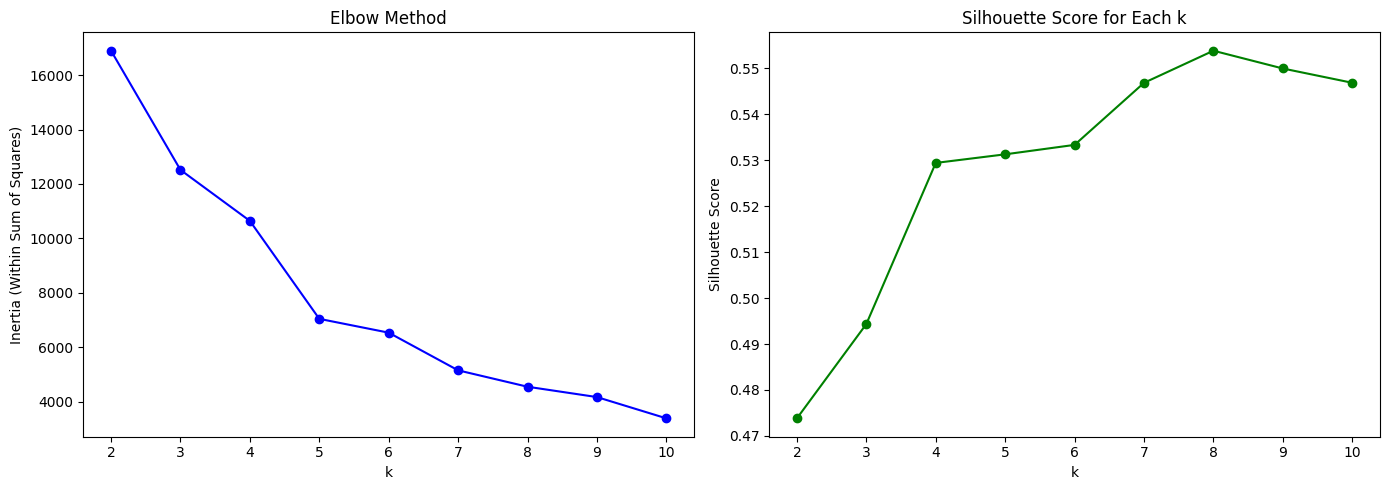

In [59]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bo-')
plt.xlabel('k')
plt.ylabel("Inertia (Within Sum of Squares)")
plt.title("Elbow Method")

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('k')
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Each k")

plt.tight_layout()
plt.show()

Based on the results, both the Elbow Method and the Silhouette Score suggest that **$k = 6$** is an optimal choice for clustering. The inertia decreases significantly as $k$ increases, but the rate of improvement slows down around $k = 6$, indicating a natural "elbow" point. At the same time, the Silhouette Score reaches its highest value at $k = 6$, suggesting that the clusters are both well-separated and compact. Therefore, choosing 6 clusters offers a good balance between clustering quality and model simplicity.

We do a second time KMeans with the best number of clusters :

In [60]:
best_k = 6
optimal_kmeans = KMeans(n_clusters=best_k, n_init='auto')
customer_df['Cluster_KMeans'] = optimal_kmeans.fit_predict(X_scaled)

## Interpretation

After performing clustering, we analyze the characteristics of each group by computing the average of the standardized features within each cluster. This helps us understand how each cluster differs in terms of behavior or attributes like number of orders, total quantity, average unit price, and recency. By transforming the scaled data into a DataFrame and merging it with the cluster labels, we can calculate the mean profile for each cluster. To visualize these profiles, radar charts and heatmaps are useful tools to highlight the relative strengths and weaknesses of each cluster across all dimensions.

In [61]:
features_names = ['NumOrders', 'TotalQuantity', 'AvgUnitPrice', 'Recency', 'PurchaseFrequency']
X_scaled_df = pd.DataFrame(X_scaled, index=customer_df.index, columns=features_names)
X_scaled_df['Cluster'] = customer_df['Cluster_KMeans']
cluster_profiles = X_scaled_df.groupby('Cluster').mean()
cluster_profiles_T = cluster_profiles.T

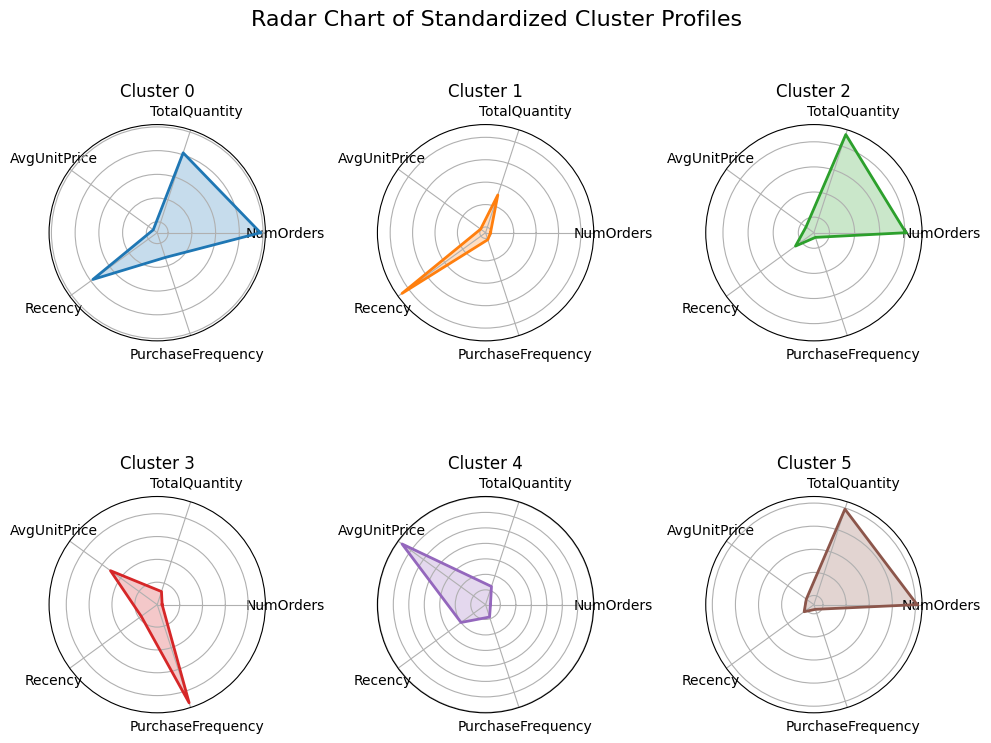

In [62]:
# Radar chart setup
categories = cluster_profiles_T.index.tolist()
n_clusters = cluster_profiles_T.shape[1]
colors = colormaps.get_cmap('tab10')

plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    values = cluster_profiles_T.iloc[:, i].values.tolist()
    values += values[:1]
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax = plt.subplot(2, int(np.ceil(n_clusters / 2)), i+1, polar=True)
    ax.plot(angles, values, color=colors(i), linewidth=2)
    ax.fill(angles, values, color=colors(i), alpha=0.25)
    ax.set_title(f'Cluster {i}', size=12)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticklabels([])

plt.suptitle("Radar Chart of Standardized Cluster Profiles", size=16)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


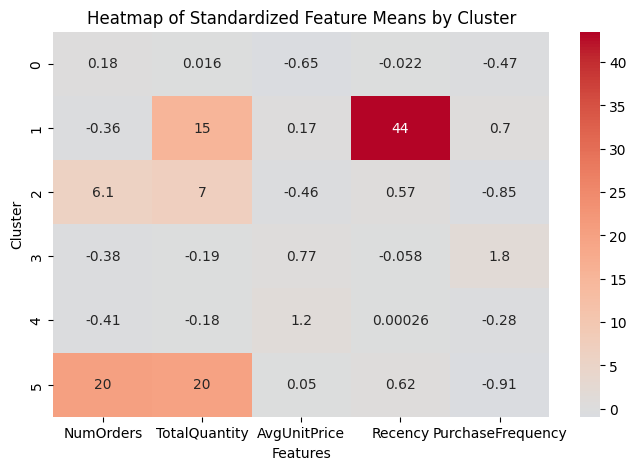

In [63]:
# Heatmap of cluster profiles
plt.figure(figsize=(8, 5))
sns.heatmap(cluster_profiles, annot=True, cmap="coolwarm", center=0)
plt.title("Heatmap of Standardized Feature Means by Cluster")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.show()

Based on those visualizations, we can make more sens of each profile :

**Cluster 0**: These customers are characterized by a moderate total quantity of purchases and a moderate average unit price. They have a relatively high number of orders and moderate recency, meaning they have made purchases somewhat recently. Their purchase frequency is moderate, indicating they shop periodically but not excessively.

**Cluster 1**: This group of customers has a low total quantity of purchases and a moderate average unit price. They place a low number of orders and have low recency, indicating they haven't made purchases recently. Their purchase frequency is also low, suggesting infrequent shopping behavior.

**Cluster 2**: Customers in this cluster exhibit a high total quantity of purchases and a high average unit price. They place a moderate number of orders and have moderate recency. Their purchase frequency is moderate, indicating a balanced shopping pattern with occasional high-value purchases.

**Cluster 3**: These customers have a low total quantity of purchases and a low average unit price. They place a low number of orders and have high recency, meaning they have made purchases recently. Their purchase frequency is low, indicating they do not shop often but have engaged with the business recently.

**Cluster 4**: Representing a balanced profile, customers in this cluster have moderate values across all metrics: total quantity, average unit price, number of orders, recency, and purchase frequency. This suggests a consistent and moderate level of engagement with the products or services.

**Cluster 5**: This cluster includes customers who make a high total quantity of purchases and have a high average unit price. They place a high number of orders and have high recency, indicating active and ongoing engagement. Their purchase frequency is high, suggesting they are frequent shoppers who make regular purchases.